<a href="https://colab.research.google.com/github/gustavohroos/treinamento-h2ia/blob/main/MLP/MLPClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from sklearn.preprocessing import StandardScaler
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tqdm import trange
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

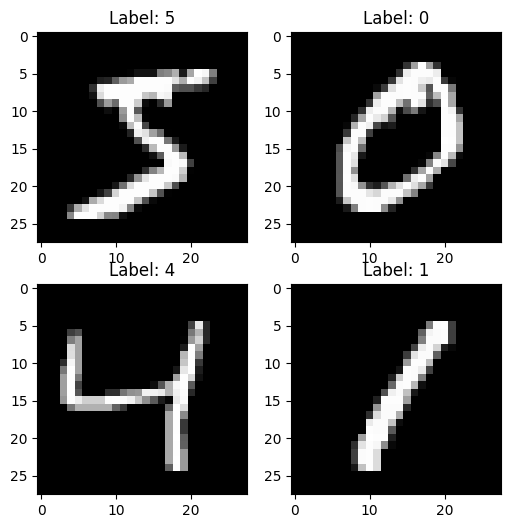

In [34]:
def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    X_train = X_train.reshape([X_train.shape[0], -1])
    X_val = X_val.reshape([X_val.shape[0], -1])
    X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(flatten=True)
plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [35]:
class Layer:
    def forward(self, input):
        return input

    def backward(self, input, grad_output):
        num_units = input.shape[1]

        d_layer_d_input = np.eye(num_units)

        return np.dot(grad_output, d_layer_d_input)

In [36]:
class ReLU(Layer):
    def forward(self, input):
        return np.maximum(input, 0)

    def backward(self, input, grad_output):
        return grad_output * (input > 0)

In [37]:
class Dense(Layer):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))

    def forward(self, input):
        return np.dot(input, self.weights)

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)

        assert grad_weights.shape == self.weights.shape

        self.weights = self.weights - self.learning_rate * grad_weights

        return grad_input


In [38]:
def softmax_crossentropy_with_logits(logits, target):
    logits_for_answers = logits[:, target]
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))

    return xentropy

def grad_softmax_crossentropy_with_logits(logits, target):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), target] = 1

    softmax = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)

    return (- ones_for_answers + softmax) / logits.shape[0]

In [39]:
class MLP:

    def __init__(self):
        self.network = []

    def add_layer(self, layer, hidden=True):
        self.network.append(layer)
        if hidden: self.network.append(ReLU())

    def forward(self, X):
        activations = []
        input = X

        for layer in self.network:
            activations.append(layer.forward(input))
            input = activations[-1]


        assert len(activations) == len(self.network)

        return activations

    def predict(self, X):
        logits = self.forward(X)[-1]
        return np.argmax(logits, axis=-1)

    def fit(self, X, y):

        layer_activations = self.forward(X)
        layer_inputs = [X]+layer_activations
        logits = layer_activations[-1]

        self.loss = softmax_crossentropy_with_logits(logits, y)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y)

        for layer_index in range(len(self.network))[::-1]:
            layer = self.network[layer_index]

            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad)

        return self.loss

    def print_layers(self):
        count = 0
        count_layer = 1
        for index, layer in enumerate(self.network):
            if count%2 == 0:
                print(f'Layer {count_layer} shape: {layer.weights.shape}')
                count_layer += 1
            count +=1

In [40]:
model = MLP()
model.add_layer(Dense(X_train.shape[1], 200))
model.add_layer(Dense(200, 200))
model.add_layer(Dense(200, 100))
model.add_layer(Dense(100, 10), hidden=False)
model.print_layers()

Layer 1 shape: (784, 200)
Layer 2 shape: (200, 200)
Layer 3 shape: (200, 100)
Layer 4 shape: (100, 10)


In [41]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)

    if shuffle: indices = np.random.permutation(len(inputs))

    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle: excerpt = indices[start_idx:start_idx + batchsize]
        else: excerpt = slice(start_idx, start_idx + batchsize)

        yield inputs[excerpt], targets[excerpt]

def train_epochs(X_train, y_train, model, X_val, y_val):
    train_log = []
    val_log = []
    print("Untrained network")
    print("Train accuracy:",np.mean(model.predict(X_train)==y_train))
    print("Val accuracy:",np.mean(model.predict(X_val)==y_val))
    for epoch in range(20):
        for x_batch,y_batch in iterate_minibatches(X_train,y_train,batchsize=128,shuffle=True):
            model.fit(x_batch,y_batch)
        train_log.append(np.mean(model.predict(X_train)==y_train))
        val_log.append(np.mean(model.predict(X_val)==y_val))
        # clear_output()
        print("Epoch",epoch+1)
        print("Train accuracy:",train_log[-1])
        print("Val accuracy:",val_log[-1])
    return train_log, val_log

In [42]:
model = MLP()
model.add_layer(Dense(784, 200))
model.add_layer(Dense(200, 200))
model.add_layer(Dense(200, 200))
model.add_layer(Dense(200, 100))
model.add_layer(Dense(100, 200))
model.add_layer(Dense(200, 10), hidden=False)

In [43]:
train_log, val_log = train_epochs(X_train, y_train, model, X_val, y_val)

Untrained network
Train accuracy: 0.11432
Val accuracy: 0.1068


100%|██████████| 390/390 [00:07<00:00, 54.30it/s]


Epoch 1
Train accuracy: 0.93306
Val accuracy: 0.9374


100%|██████████| 390/390 [00:04<00:00, 89.51it/s]


Epoch 2
Train accuracy: 0.96072
Val accuracy: 0.9574


100%|██████████| 390/390 [00:04<00:00, 79.22it/s]


Epoch 3
Train accuracy: 0.97376
Val accuracy: 0.9697


100%|██████████| 390/390 [00:04<00:00, 88.38it/s]


Epoch 4
Train accuracy: 0.97614
Val accuracy: 0.9679


100%|██████████| 390/390 [00:04<00:00, 80.02it/s]


Epoch 5
Train accuracy: 0.98456
Val accuracy: 0.9736


100%|██████████| 390/390 [00:04<00:00, 82.53it/s]


Epoch 6
Train accuracy: 0.98802
Val accuracy: 0.9757


100%|██████████| 390/390 [00:05<00:00, 68.70it/s]


Epoch 7
Train accuracy: 0.99146
Val accuracy: 0.9767


100%|██████████| 390/390 [00:06<00:00, 63.98it/s]


Epoch 8
Train accuracy: 0.99276
Val accuracy: 0.9766


100%|██████████| 390/390 [00:04<00:00, 87.09it/s]


Epoch 9
Train accuracy: 0.9929
Val accuracy: 0.9754


100%|██████████| 390/390 [00:06<00:00, 63.69it/s]


Epoch 10
Train accuracy: 0.99642
Val accuracy: 0.977


100%|██████████| 390/390 [00:04<00:00, 87.92it/s]


Epoch 11
Train accuracy: 0.99734
Val accuracy: 0.9774


100%|██████████| 390/390 [00:06<00:00, 63.56it/s]


Epoch 12
Train accuracy: 0.99502
Val accuracy: 0.9756


100%|██████████| 390/390 [00:04<00:00, 82.62it/s]


Epoch 13
Train accuracy: 0.99816
Val accuracy: 0.9778


100%|██████████| 390/390 [00:06<00:00, 63.91it/s]


Epoch 14
Train accuracy: 0.99908
Val accuracy: 0.979


100%|██████████| 390/390 [00:05<00:00, 77.89it/s]


Epoch 15
Train accuracy: 0.99862
Val accuracy: 0.9779


100%|██████████| 390/390 [00:05<00:00, 69.20it/s]


Epoch 16
Train accuracy: 0.9994
Val accuracy: 0.9798


100%|██████████| 390/390 [00:04<00:00, 87.93it/s]


Epoch 17
Train accuracy: 0.9999
Val accuracy: 0.9809


100%|██████████| 390/390 [00:05<00:00, 71.06it/s]


Epoch 18
Train accuracy: 0.9997
Val accuracy: 0.9795


100%|██████████| 390/390 [00:04<00:00, 86.04it/s]


Epoch 19
Train accuracy: 1.0
Val accuracy: 0.9813


100%|██████████| 390/390 [00:04<00:00, 80.46it/s]


Epoch 20
Train accuracy: 0.99994
Val accuracy: 0.981


In [44]:
def plot_predictions(data, target, prediction, n_plots=8,figsize=[15,15]):
  plt.figure(figsize=figsize)
  for i in range(n_plots):
      plt.subplot(int(n_plots/2), int(n_plots/2), i+1)
      plt.title(f'Target: {target[i]}   Predicted: {prediction[i]}')
      plt.imshow(data[i].reshape([28,28]),cmap='gray');

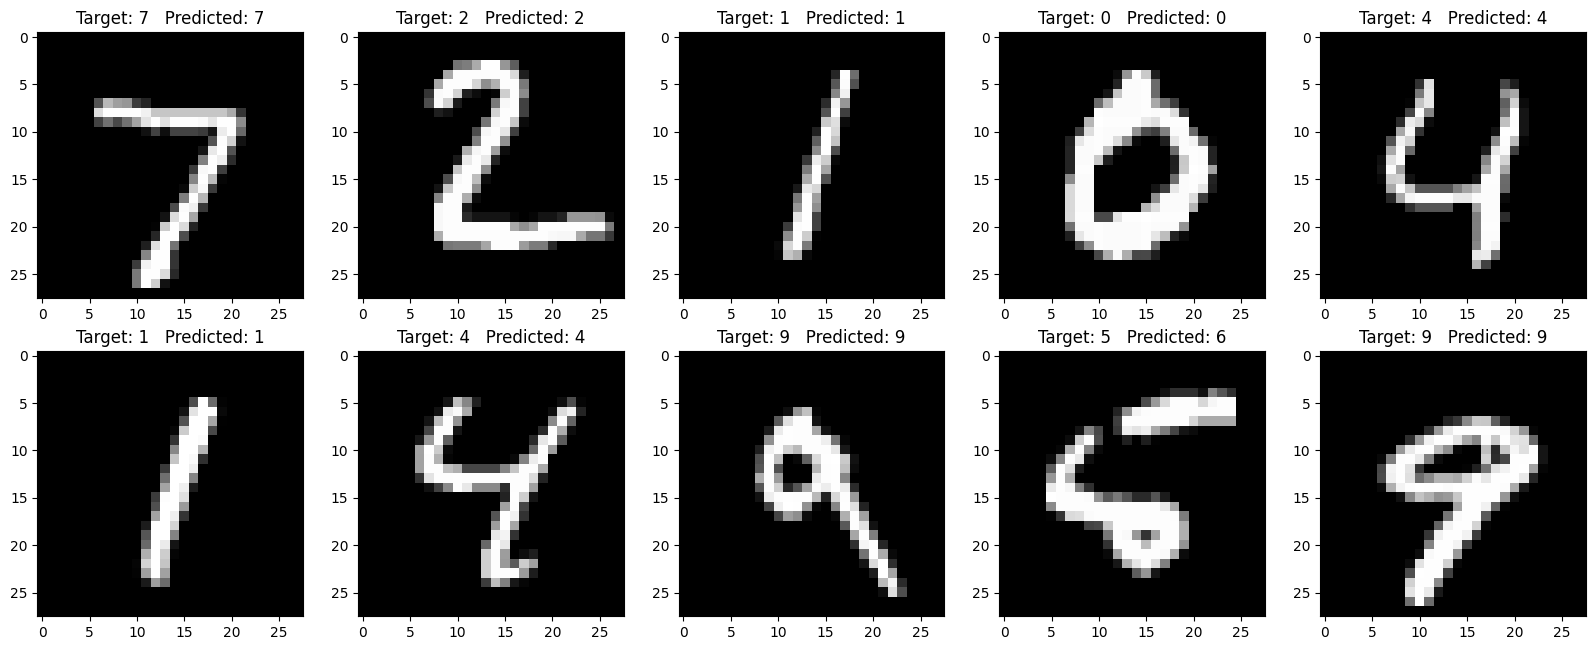

In [45]:
prediction = model.predict(X_test)
plot_predictions(X_test, y_test, prediction, n_plots=10, figsize=[20,20])

In [46]:
print(f'Final accuracy w/ X_test: {np.mean(prediction==y_test)}')

Final accuracy w/ X_test: 0.9811


In [47]:
class Dense_with_biases(Layer):
    def __init__(self, n_inputs, n_outputs, learning_rate=0.1):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0,
                                        scale=np.sqrt(2/(n_inputs+n_outputs)),
                                        size=(n_inputs, n_outputs))
        self.biases = np.zeros(n_outputs)

    def forward(self, input):
        return np.dot(input, self.weights) + self.biases

    def backward(self, input, grad_output):
        grad_input = np.dot(grad_output, self.weights.T)
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = grad_output.mean(axis=0)*input.shape[0]

        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape

        self.weights = self.weights - self.learning_rate * grad_weights
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

In [48]:
model2 = MLP()
model2.add_layer(Dense_with_biases(784, 200))
model2.add_layer(Dense_with_biases(200, 200))
model2.add_layer(Dense_with_biases(200, 200))
model2.add_layer(Dense_with_biases(200, 100))
model2.add_layer(Dense_with_biases(100, 200))
model2.add_layer(Dense_with_biases(200, 10), hidden=False)

In [49]:
train_log2, val_log2 = train_epochs(X_train, y_train, model2, X_val, y_val)

Untrained network
Train accuracy: 0.05972
Val accuracy: 0.058


100%|██████████| 390/390 [00:06<00:00, 61.15it/s]


Epoch 1
Train accuracy: 0.9382
Val accuracy: 0.9425


100%|██████████| 390/390 [00:04<00:00, 82.60it/s]


Epoch 2
Train accuracy: 0.95942
Val accuracy: 0.9596


100%|██████████| 390/390 [00:05<00:00, 67.16it/s]


Epoch 3
Train accuracy: 0.96224
Val accuracy: 0.9574


100%|██████████| 390/390 [00:05<00:00, 77.95it/s]


Epoch 4
Train accuracy: 0.97902
Val accuracy: 0.9697


100%|██████████| 390/390 [00:04<00:00, 81.83it/s]


Epoch 5
Train accuracy: 0.98584
Val accuracy: 0.974


100%|██████████| 390/390 [00:06<00:00, 60.38it/s]


Epoch 6
Train accuracy: 0.9878
Val accuracy: 0.9742


100%|██████████| 390/390 [00:04<00:00, 81.19it/s]


Epoch 7
Train accuracy: 0.98706
Val accuracy: 0.9737


100%|██████████| 390/390 [00:06<00:00, 60.61it/s]


Epoch 8
Train accuracy: 0.98704
Val accuracy: 0.9698


100%|██████████| 390/390 [00:04<00:00, 83.79it/s]


Epoch 9
Train accuracy: 0.99288
Val accuracy: 0.9744


100%|██████████| 390/390 [00:06<00:00, 62.81it/s]


Epoch 10
Train accuracy: 0.99484
Val accuracy: 0.9765


100%|██████████| 390/390 [00:04<00:00, 81.87it/s]


Epoch 11
Train accuracy: 0.9964
Val accuracy: 0.9782


100%|██████████| 390/390 [00:06<00:00, 64.05it/s]


Epoch 12
Train accuracy: 0.98894
Val accuracy: 0.9667


100%|██████████| 390/390 [00:04<00:00, 81.06it/s]


Epoch 13
Train accuracy: 0.9971
Val accuracy: 0.9764


100%|██████████| 390/390 [00:04<00:00, 78.97it/s]


Epoch 14
Train accuracy: 0.99688
Val accuracy: 0.9762


100%|██████████| 390/390 [00:05<00:00, 69.96it/s]


Epoch 15
Train accuracy: 0.99802
Val accuracy: 0.9784


100%|██████████| 390/390 [00:04<00:00, 82.88it/s]


Epoch 16
Train accuracy: 0.98922
Val accuracy: 0.9736


100%|██████████| 390/390 [00:06<00:00, 61.42it/s]


Epoch 17
Train accuracy: 0.99584
Val accuracy: 0.9763


100%|██████████| 390/390 [00:04<00:00, 83.90it/s]


Epoch 18
Train accuracy: 0.99682
Val accuracy: 0.9768


100%|██████████| 390/390 [00:06<00:00, 62.70it/s]


Epoch 19
Train accuracy: 0.99876
Val accuracy: 0.979


100%|██████████| 390/390 [00:04<00:00, 82.43it/s]


Epoch 20
Train accuracy: 0.99964
Val accuracy: 0.9797


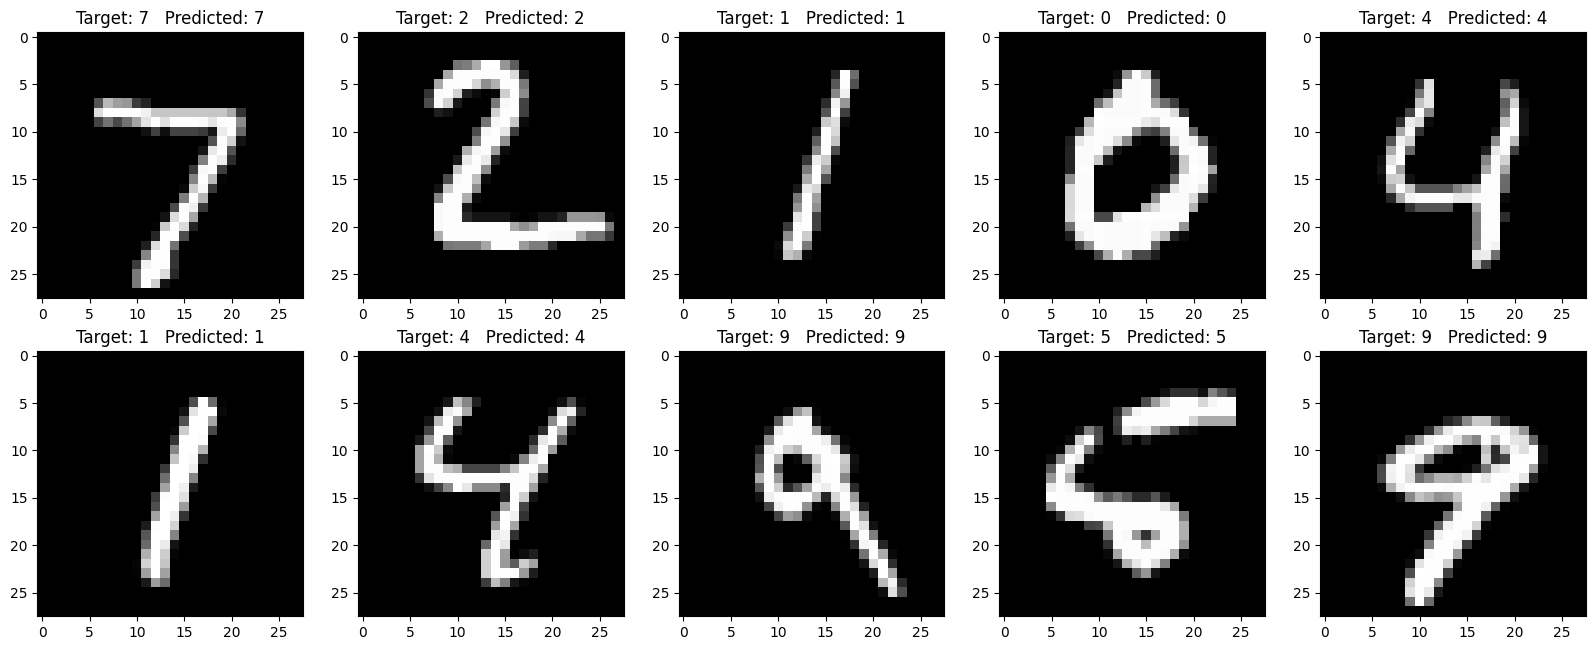

In [50]:
prediction2 = model2.predict(X_test)
plot_predictions(X_test, y_test, prediction2, n_plots=10, figsize=[20,20])

In [51]:
print(f'Final accuracy w/ X_val: {np.mean(prediction2==y_test)}')

Final accuracy w/ X_val: 0.9789


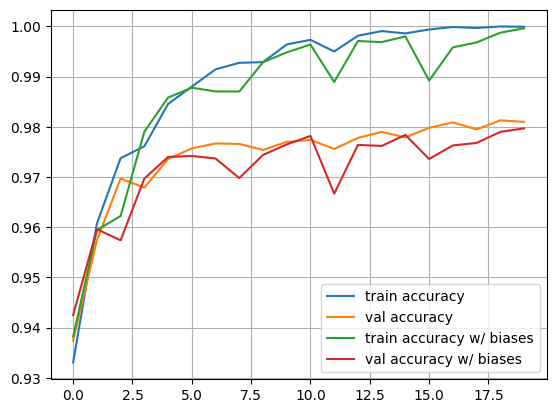

In [52]:
plt.plot(train_log,label='train accuracy')
plt.plot(val_log,label='val accuracy')
plt.plot(train_log2,label='train accuracy w/ biases')
plt.plot(val_log2,label='val accuracy w/ biases')
plt.legend(loc='best')
plt.grid()
plt.show()

##References
https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9<br/>
https://www.youtube.com/watch?v=0oWnheK-gGk<br/>
https://www.kaggle.com/code/vitorgamalemos/multilayer-perceptron-from-scratch/notebook